In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import datasets
import utils
import gmm_impute
import gmm_dae
import pickle_utils as pu
import numpy as np
import pandas as pd
import itertools as it
import missing_bayesian_mixture as mbm
import os
import denoising_ae
import category_dae
import tensorflow as tf
import missForest
import missForest_GP

from sklearn.mixture import BayesianGaussianMixture

import imp
imp.reload(utils)
imp.reload(datasets)
imp.reload(mbm)
imp.reload(category_dae)
imp.reload(missForest)
imp.reload(missForest_GP)
imp.reload(denoising_ae)

<module 'denoising_ae' from '/home/adria/MIMIC/ts-baselines/timeless-imputation/denoising_ae.py'>

In [3]:
from IPython.display import HTML
def df_view(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

In [14]:
dsets = datasets.datasets()

+++ Importing Ionosphere
V2 ; must have more than 1 possible value
+++ Importing BreastCancer
+++ Importing Shuttle
+++ Importing LetterRecognition
+++ Importing BostonHousing
+++ Importing Soybean
+++ Importing Servo


In [15]:
len(dsets["Ionosphere"][0])

351

In [22]:
tests_to_perform = []
for b in dsets.items():
    def do_mcar_rows(dataset_, proportion):
        return utils.mcar_rows(dataset_, proportion**.5, proportion**.5)
    def do_mar_rows(dataset_, proportion):
        return utils.mar_rows(dataset_, proportion**.5, proportion**.5,
                              deciding_missing_proportion=0.2)
    def do_mnar_rows(dataset_, proportion):
        return utils.mnar_rows(dataset_, proportion**.5, proportion**.5,
                            missing_proportion_nonrandom=0.0)

    for c in [(datasets.memoize(utils.mcar_total), 'MCAR_total'),
              (datasets.memoize(do_mcar_rows), 'MCAR_rows'),
              (datasets.memoize(do_mnar_rows), 'MNAR_rows'),
              (datasets.memoize(do_mar_rows), 'MAR_rows')]:
        for d in [.1, .3, .5, .7, .9]:
            for e in ['mean_std']:
                tests_to_perform.append((b, c, d, e))
del b, c, d, e

In [17]:
imp.reload(missForest)


<module 'missForest' from '/home/adria/MIMIC/ts-baselines/timeless-imputation/missForest.py'>

In [30]:
_ds = dict((x, dsets[x]) for x in ["BostonHousing", "Servo", "Ionosphere"
    # "Soybean", "BreastCancer"
])
baseline = datasets.benchmark([#'MICE': datasets.memoize(utils.impute_mice),
        ('mean', missForest.impute),
        ('GMM', lambda log, d, full_data: missForest.impute(
            log, d, full_data, max_iterations=0,
            initial_impute=mbm.mf_initial_impute)),
        ('Missforest_mult', datasets.memoize(utils.impute_missforest)),
        ('MICE', datasets.memoize(utils.impute_mice)),
        ('GP_mog_prior', lambda log_path, d, full_data: missForest.impute(
                log_path, d, full_data)),
        ('GP_KNN_prior', lambda log_path, d, full_data: missForest.impute(
                log_path, d, full_data)),
        ('GP_mog', lambda log_path, d, full_data: missForest.impute(
            log_path, d, full_data, sequential=False, print_progress=True,
            predictors=(missForest_GP.UncertainGPClassification,
                        missForest_GP.UncertainGPRegression),
            optimize_gp=False, use_previous_prediction=False,
            ARD=False, impute_name_replace=('GP', 'GMM'), max_iterations=1)),
        ('GP_KNN', lambda log_path, d, full_data: missForest.impute(
            log_path, d, full_data, sequential=False, print_progress=True,
            predictors=(missForest_GP.KNNGPClassification,
                        missForest_GP.KNNGPRegression),
            optimize_gp=True, use_previous_prediction=False,
            ARD=True, n_neighbours=5, knn_type='kernel_avg', max_iterations=1)),
        #('GP_KNN_noopt', lambda log_path, d, full_data: missForest.impute(
        #    log_path, d, full_data, sequential=False, print_progress=True,
        #    predictors=(missForest_GP.KNNGPClassification,
        #                missForest_GP.KNNGPRegression),
        #    optimize_gp=False, use_previous_prediction=False,
        #    ARD=True, n_neighbours=5, knn_type='kernel_avg', max_iterations=1)),

], _ds, tests_to_perform, do_not_compute=True)

Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_total_0.1/log_likelihood.pkl


 /home/adria/MIMIC/ts-baselines/timeless-imputation/utils.py:352: RuntimeWarning:overflow encountered in true_divide


Calculating log-likelihood
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_total_0.3/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_total_0.5/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_total_0.7/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_total_0.9/log_likelihood.pkl


 /home/adria/venv/lib/python3.5/site-packages/numpy/core/_methods.py:112: RuntimeWarning:invalid value encountered in subtract


Calculating log-likelihood
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_rows_0.1/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MCAR_rows_0.3/log_likelihood.pkl
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_Ionosphere_MNAR_rows_0.1/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_BostonHousing_MCAR_total_0.1/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_BostonHousing_MCAR_total_0.3/log_likelihood.pkl
Calculating log-likelihood
Calculating log-likelihood
Loaded log_likelihood from file: impute_benchmark/imputed_GMM_BostonHousing_MCAR_total_0.5/log_likelihood.pkl
Calculating log-likelihood
C

In [31]:
baseline.loc["mean_std", :].drop(["LetterRecognition", "Shuttle", "Soybean", "BreastCancer", "Servo"], axis=0)
# .drop([("NRMSE", "MF_py"), ("PFC", "MF_py"), ("RMSE", "MF_py")], axis=1)  # 

NRMSE                                   \
                                   GMM    GP_KNN GP_KNN_prior    GP_mog   
BostonHousing MAR_rows   0.1  0.453648  0.450627          NaN  0.529305   
                         0.3  0.453481  0.652405          NaN  0.540008   
                         0.5  0.570088  0.723566          NaN  0.725005   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
              MCAR_rows  0.1  0.337464  0.350101          NaN       NaN   
                         0.3  0.463568  0.627986          NaN       NaN   
                         0.5       NaN       NaN          NaN       NaN   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
              MCAR_total 0.1  0.373664  0.328661          NaN       NaN   
                         0.3  0.413930  0.392216          NaN       NaN   
                         0.5  0.473618  0.585738          NaN       NaN   
                         0.7  0.557055  0.725555          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
              MNAR_rows  0.1  0.976971  1.499284     1.000432  1.377195   
                         0.3  0.910232  1.016351          NaN  0.993202   
                         0.5  1.296891  1.348987          NaN  1.346255   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
Ionosphere    MAR_rows   0.1       NaN       NaN          NaN       NaN   
                         0.3       NaN       NaN          NaN       NaN   
                         0.5       NaN       NaN          NaN       NaN   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
              MCAR_rows  0.1  0.822315  0.600628          NaN       NaN   
                         0.3  0.816513  0.705784          NaN       NaN   
                         0.5       NaN       NaN          NaN       NaN   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   
              MCAR_total 0.1  0.809208  0.665222          NaN  0.787725   
                         0.3  0.868233  0.694256          NaN  0.830140   
                         0.5  0.840861  0.756948          NaN  0.864980   
                         0.7  0.889912  0.927205          NaN  0.912161   
                         0.9  0.978690  0.944059          NaN  0.938717   
              MNAR_rows  0.1  1.946424  2.088510          NaN       NaN   
                         0.3       NaN       NaN          NaN       NaN   
                         0.5       NaN       NaN          NaN       NaN   
                         0.7       NaN       NaN          NaN       NaN   
                         0.9       NaN       NaN          NaN       NaN   

                                                                               \
                             GP_mog_prior      MICE Missforest_mult      mean   
BostonHousing MAR_rows   0.1          NaN  0.480477        0.349818  0.808056   
                         0.3          NaN  0.473397        0.389004  0.703268   
                         0.5          NaN  0.552061        0.515846  0.815455   
                         0.7          NaN       NaN             NaN       NaN   
                         0.9          NaN       NaN             NaN       NaN   
              MCAR_rows  0.1          NaN  0.401014        0.284003  0.710766   
                         0.3          NaN  0.518942        0.410368  0.723051   
                         0.5          NaN       NaN             NaN       NaN   
                         0.7          NaN       NaN             NaN     

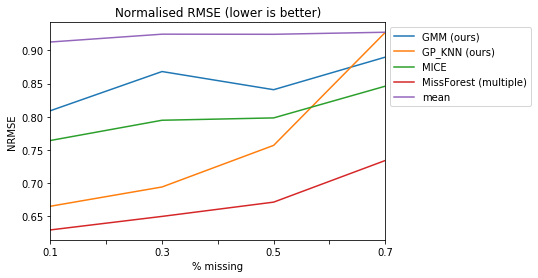

In [98]:
data = baseline.loc[("mean_std", "Ionosphere", "MCAR_total"), "NRMSE"].drop("0.9", axis=0).drop(["GP_mog_unopt", "GP_KNN_noopt"], axis=1)
data.columns = pd.Index(['GMM (ours)', 'GP_KNN (ours)', 'MICE', 'MissForest (multiple)', 'mean'])
plt.figure()
data.plot()
plt.legend(loc=0, bbox_to_anchor=(1.0, 1.0))
plt.title("Normalised RMSE (lower is better)")
plt.xlabel("% missing")
plt.ylabel("NRMSE")
plt.savefig("/tmp/nrmse.png", bbox_inches="tight")

In [99]:
print(data.to_string())

     GMM (ours)  GP_KNN (ours)      MICE  MissForest (multiple)      mean
0.1    0.809208       0.665222  0.764321               0.629526  0.912747
0.3    0.868233       0.694256  0.794809               0.649896  0.924532
0.5    0.840861       0.756948  0.798345               0.671400  0.924360
0.7    0.889912       0.927205  0.846144               0.734135  0.927450


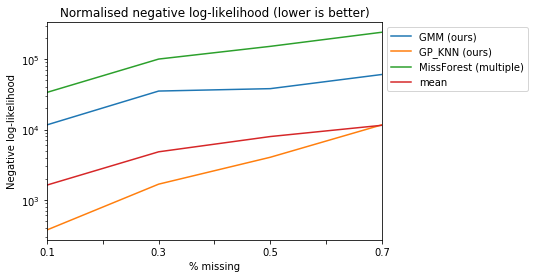

In [96]:
data = baseline.loc[("mean_std", "Ionosphere", "MCAR_total"), "norm_log_l"].drop("0.9", axis=0).drop(["GP_mog_unopt", "GP_KNN_noopt", "MICE"], axis=1)
data.columns = pd.Index(['GMM (ours)', 'GP_KNN (ours)', 'MissForest (multiple)', 'mean'])
(-data).plot()
plt.yscale('log')
plt.legend(loc=0, bbox_to_anchor=(1.0, 1.0))
plt.title("Normalised negative log-likelihood (lower is better)")
plt.xlabel("% missing")
plt.ylabel("Negative log-likelihood")
plt.savefig("/tmp/n_ll.png", bbox_inches="tight")

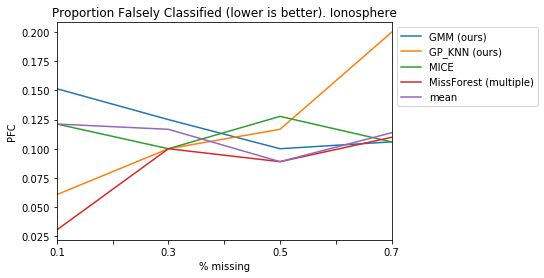

In [91]:
data = baseline.loc[("mean_std", "Ionosphere", "MCAR_total"), "PFC"].drop("0.9", axis=0).drop(["GP_mog_unopt", "GP_KNN_noopt"], axis=1)
data.columns = pd.Index(['GMM (ours)', 'GP_KNN (ours)', 'MICE', 'MissForest (multiple)', 'mean'])
plt.figure()
data.clip(0, 0.2).plot()
plt.legend(loc=0, bbox_to_anchor=(1.0, 1.0))
plt.title("Proportion Falsely Classified (lower is better). Ionosphere")
plt.xlabel("% missing")
plt.ylabel("PFC")
plt.savefig("/tmp/pfc.png", bbox_inches="tight")

In [11]:
baseline.loc[("mean_std", "Ionosphere", "MCAR_total"), ("norm_log_l")]

,GMM,GP_KNN,GP_KNN_noopt,GP_mog_unopt,MICE,Missforest_mult,mean
0.1,-1521.264231,-inf,-958.230171,-inf,-2.241627e+307,-36248.934613,-470.459094
0.3,-6201.913997,-inf,-2751.008743,-inf,-1.190968e+308,-107979.638273,-1356.218497
0.5,-5248.857709,-inf,-4710.285850,-inf,-5.195975e+307,-163106.859010,-2288.457781
0.7,-8978.842505,-inf,-6622.550238,-inf,-7.838111e+306,-259664.808550,-3056.185084
0.9,NaN,NaN,-8299.294782,NaN,NaN,-213697.225086,NaN


In [32]:
df_view(pu.load("experiments/processed_data.pkl.gz"))

In [170]:
imp.reload(mbm)
bayesgmm = datasets.benchmark({'BGMM_50': (lambda p, d, full_data: mbm.impute_bayes_gmm(
    p, d, full_data=full_data, number_imputations=100, n_components=50))
                              }, dsets, do_not_compute=True)

In [295]:
results = pd.concat([baseline, bayesgmm, nnresults], axis=1).loc['mean_std']
results = results.drop([('total_cats', 'MissForest'), ('total_cats', 'MLP_2x256_SGD')], axis=1)
results.sort_index(level=[0,1], inplace=True, axis=1)
results

In [319]:
# Export the results to LaTeX

s = (("""\\documentclass[12pt,a3paper,landscape,oneside]{article}
\\usepackage[utf8]{inputenc}
\\usepackage[english]{babel}
\\usepackage{setspace}
\\usepackage{parskip}
\\usepackage{color}
\\usepackage{amssymb,amsmath,amsfonts}
\\usepackage{graphicx}
\\usepackage{hyperref}
\\hypersetup{colorlinks,breaklinks,urlcolor=blue,linkcolor=blue} % Set link colors throughout the document
\\usepackage[left=2cm,right=2cm,top=2cm,bottom=2cm]{geometry}
\\usepackage{enumitem}   
\\usepackage{import}
\\usepackage{multicol}

\\usepackage{csquotes}
\\begin{document}\n""" + results.to_latex() + "\n\\end{document}")
     .replace("\\toprule", "\\hline")
     .replace("\\bottomrule", "\\hline")
     .replace("\\midrule", "\\hline"))

with open("measurements.tex", "w") as f:
    f.write(s)


In [ ]:
from rpy2.robjects.packages import importr
import rpy2.robjects
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri
import rpy2.rinterface
import numpy as np
import pickle_utils as pu
import pandas as pd
import collections
import utils
import os
import collections
import unittest

rpy2.robjects.pandas2ri.activate()
rpy2.robjects.numpy2ri.activate()
py2ri = rpy2.robjects.pandas2ri.py2ri
ri2py = rpy2.robjects.pandas2ri.ri2py
R = rpy2.robjects.r

base = importr("base")
R_utils = importr("utils")
mlbench = importr("mlbench")
randomForest = importr("randomForest")

In [77]:
dsets_label = datasets.datasets(exclude_labels=False)
path = "impute_benchmark"
for algo_name in ["BayesGMM", "MICE", "MissForest"]:
    for data_name, (full_data, cat_keys) in dsets_label.items():
        if data_name == 'BostonHousing':
            continue

        for ampute_fun_name in ['MCAR_total', 'MCAR_rows']:
            for proportion in [.1, .3, .5, .7, .9]:
                for norm_type in ['mean_std']:  # 'min_max']:
                    amputed_name = '{:s}_{:s}_{:.1f}'.format(
                        data_name, ampute_fun_name, proportion) 
                    imputed_path = os.path.join(
                        path, 'imputed_{:s}_{:s}.pkl.gz'.format(
                            algo_name, amputed_name))
                    if not os.path.exists(imputed_path):
                        continue
                    amputed_data = pu.load(os.path.join(path, 'amputed_'+amputed_name+'.pkl.gz'))
                    imputed_data = pu.load(imputed_path)
                    (_ad, _id), moments = utils.normalise_dataframes(
                        amputed_data, imputed_data, method=norm_type)
                    
                    to_learn = pd.concat([_id, full_data[["Class"]]], axis=1)
                    test_mask = np.random.rand(len(to_learn)) < 0.2
                    training_set = to_learn[~test_mask]
                    test_set = to_learn[test_mask]
                    
                    


+++ Importing Ionosphere
V2 ; must have more than 1 possible value
+++ Importing Soybean
+++ Importing BreastCancer
+++ Importing Servo
+++ Importing BostonHousing


AssertionError: All dataframes must have the same columns